# Аналитика заведений общественного питания (г. Москва)

## _Цель - найти место для открытия кафе_

1. [Подготовка данных к анализу](#100101)
2. [Анализ данных](#100102)
    * [2.1.Исследуем соотношение видов объектов общественного питания по количеству.](#102100)
    * [2.2.Исследуем соотношение сетевых и несетевых заведений по количеству.](#102101)
    * [2.3.Для какого вида объекта общественного питания характерно сетевое распространение?](#102102)
    * [2.4.Что характерно для сетевых заведений (количество и посадочные места)?](#102103)
    * [2.5.Опишем среднее количество посадочных мест для каждого вида объекта общественного питания. Какой вид предоставляет в среднем самое большое количество посадочных мест?](#102104)
    * [2.6.Выделим в отдельный столбец информацию об улице из столбца address.](#102105)
    * [2.7.Построим график топ-10 улиц по количеству объектов общественного питания. Воспользуемся внешней информацией и ответим на вопрос — в каких районах Москвы находятся эти улицы?](#102106)
    * [2.8.Найдем число улиц с одним объектом общественного питания. Воспользуемся внешней информацией и ответим на вопрос — в каких районах Москвы находятся эти улицы?](#102107)
    * [2.9.Посмотрим на распределение количества посадочных мест для улиц с большим количеством объектов общественного питания. Выявим закономерности.](#102108)
3. [Вывод](#100103)
4. [Рекомендации](#100104)

### 1. Подготовка данных к анализу <a id='100101'></a>

In [45]:
import pandas as pd
import re
rest = pd.read_csv('rest_data.csv')
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from nltk.stem import SnowballStemmer
from pymystem3 import Mystem
#from pandas.plotting import register_matplotlib_converters
import plotly.express as px
from plotly import graph_objects as go
import seaborn as sns
from numpy import median
pd.options.mode.chained_assignment = None
pd.options.display.max_colwidth = 100
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500) 
pd.set_option('display.width', 1000)

In [46]:
#посмотрим на данные:
rest.head(10)

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50
5,27429,СТОЛ. ПРИ ГОУ СОШ № 1051,нет,столовая,"город Москва, Абрамцевская улица, дом 15, корпус 1",240
6,148815,Брусника,да,кафе,"город Москва, переулок Сивцев Вражек, дом 6/2",10
7,20957,Буфет МТУСИ,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строение 1",90
8,20958,КПФ СЕМЬЯ-1,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строение 1",150
9,28858,Столовая МТУСИ,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строение 1",120


In [47]:
#приведем данные столбца object_name к единообразию:
rest['object_name'] = rest['object_name'].str.lower()
rest.head()

,id,object_name,chain,object_type,address,number
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,кафе «академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,кафе «вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


In [48]:
#посмотрим на данные о колонках:
rest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


In [49]:
#посмотрим есть ли незаполненные ячейки:
rest.isnull().sum()

id             0
object_name    0
chain          0
object_type    0
address        0
number         0
dtype: int64

Пропусков нет.

In [50]:
#поменяем тип колонки id на object:
rest['id'] = rest['id'].astype(object)
#проверим:
#rest.info()

In [51]:
#узнаем нет ли повторов уникальных id:
rest['id'].value_counts().sum()

15366

Повторов нет.

*********************

### 2. Анализ данных<a id='100102'></a>

**2.1.Исследуем соотношение видов объектов общественного питания по количеству.**<a id='102100'></a>

In [52]:
#узнаем количество уникальных значений в столбце object_type:
type_object = rest['object_type'].value_counts()
type_object

кафе                                 6099
столовая                             2587
ресторан                             2285
предприятие быстрого обслуживания    1923
бар                                   856
буфет                                 585
кафетерий                             398
закусочная                            360
магазин (отдел кулинарии)             273
Name: object_type, dtype: int64

В данной таблице 9 типов заведений - больше всего кафе(6099), а меньше всего кулинарий (273).

In [53]:
name_rest1 = ['Кафе', 'Столовая', 'Ресторан', 'Фаст-фуд', 'Бар', 'Буфет', 'Кафетерий', 'Закусочная', 'Кулинария']
fig = go.Figure(data=[go.Pie(labels=name_rest1, values=type_object)])
fig.show()

***************

**2.2.Исследуем соотношение сетевых и несетевых заведений по количеству.**<a id='102101'></a>

In [54]:
#узнаем количество уникальных значений в столбце chain для определения типов заведений:
share = rest['chain'].value_counts()
share

нет    12398
да      2968
Name: chain, dtype: int64

12398 несетевых заведений и 2968 сетевых. Несетевых в 4 раза больше.

In [55]:
name_rest = ['Несетевые', 'Сетевые']
fig = go.Figure(data=[go.Pie(labels=name_rest, values=share)])
fig.show()

****************

**2.3.Для какого вида объекта общественного питания характерно сетевое распространение?**<a id='102102'></a>

In [56]:
#сделаем срез сетевых заведений:
chain_rest = rest.query('chain == "да"')
#chain_rest

In [57]:
sum_chain = chain_rest['object_type'].value_counts()
sum_chain

кафе                                 1396
предприятие быстрого обслуживания     791
ресторан                              544
магазин (отдел кулинарии)              78
закусочная                             56
кафетерий                              52
бар                                    37
буфет                                  11
столовая                                3
Name: object_type, dtype: int64

In [58]:
# словарь соответствия:
names_dict = dict(zip(sum_chain.index, ['Кафе', 'Фаст-фуд', 'Ресторан', 'Кулинария', 'Закусочная', 'Кафетерий', 'Бар', 'Буфет', 'Столовая']))

name_rest2 = ['Кафе', 'Фаст-фуд', 'Ресторан', 'Кулинария', 'Закусочная', 'Кафетерий', 'Бар', 'Буфет', 'Столовая']

fig2 = go.Figure(data=[go.Pie(labels=name_rest2, values=sum_chain)])
fig2.show()

In [59]:
#найдем среднее количество посадочных мест в сетевых заведениях:
chain_rest.describe()

,number
count,2968.000000
mean,52.919811
std,57.140644
min,0.000000
25%,15.000000
50%,40.000000
75%,72.000000
max,580.000000


Среднее количество посадочных мест - 53, но по медиане - 40, значит есть значительные расхождения между заведениями, или много завдений без посадочных мест или наоборот с очень большим их количеством.

***************
* _Посмотрим на сети с самым большим количеством ресторанов._

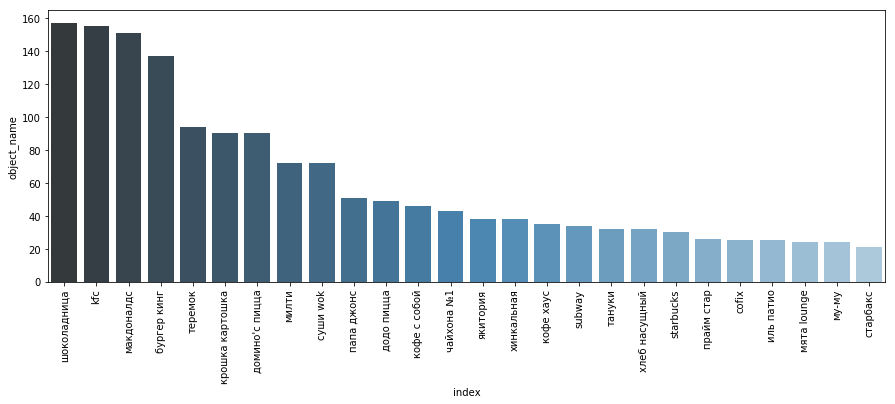

In [60]:
big_chain = chain_rest['object_name'].value_counts().reset_index()
big_chain = big_chain.query('object_name > 20')
#print(big_chain)

plt.figure(figsize=(15, 5))
sns.barplot(x='index', y='object_name', palette="Blues_d", data=big_chain)
plt.xticks(rotation=90)
plt.show()

На первых местах - Шоколадница, KFC, Макдоналдс, Бургер Кинг.

Более всего для сетевого типа характерно - кафе, предприятие быстрого обслуживания (фаст-фуд) и ресторан. Для несетевого типа - кафе, столовая и ресторан. Среднее количество посадочных мест в сетевом типе - 53, а в несетевом - 61.

Обращает на себя внимание факт, что сетевых столовых в Москве практически нет, а в несетевом секторе они на втором месте - 20,8%. Возможно в реальности это просто разница в названиях, что в одном секторе столовая, то в другом фаст-фуд, оно же предприятие быстрого обслуживания.)))

*************
* _Посмотрим для интереса на несетевые заведения:_

In [61]:
#сделаем срез несетевых заведений:
non_chain = rest.query('chain == "нет"')
#non_chain

In [62]:
#найдем среднее количество посадочных мест в сетевых заведениях:
non_chain.describe()

,number
count,12398.000000
mean,61.133731
std,78.284046
min,0.000000
25%,12.000000
50%,40.000000
75%,80.000000
max,1700.000000


Среди несетевых заведений расхождение между средним и медианой еще больше.

In [63]:
non_chain_sum = non_chain['object_type'].value_counts()
#non_chain_sum

In [64]:
non_chain2 = ['Кафе', 'Столовая', 'Ресторан', 'Фаст_фуд', 'Бар', 'Буфет', 'Кафетерий', 'Закусочная', 'Кулинария']
fig3 = go.Figure(data=[go.Pie(labels=non_chain2, values=non_chain_sum)])
fig3.show()

У несетевых заведений преобладает так же кафе(37,9%), затем есть существенные различия - столовая (20,8%), ресторан (14%) и фаст_фуд (9, 13%).
*****************

**2.4.Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?**<a id='102103'></a>

In [65]:
set1 = chain_rest.groupby('object_type')[['number']].sum().join(chain_rest.groupby('object_type')[['id']].count()).reset_index()
set1['ratio'] = set1['number'] / set1['id']
set1

,object_type,number,id,ratio
0,бар,1962,37,53.027027
1,буфет,140,11,12.727273
2,закусочная,805,56,14.375000
3,кафе,66208,1396,47.426934
4,кафетерий,638,52,12.269231
5,магазин (отдел кулинарии),677,78,8.679487
6,предприятие быстрого обслуживания,31772,791,40.166877
7,ресторан,54527,544,100.233456
8,столовая,337,3,112.333333


Для сетевых заведений характерно (возьмем самые распространенные типы: кафе, предприятие быстрого обслуживания(фаст-фуд), ресторан) - большое количество заведений с довольно средним количеством посадочных мест у кафе(47) и фаст-фуда(40) и с большим количеством посадочных мест у ресторанов(100). Напомню среднее = 53, медиана = 40.
***************

* _Посмотрим и на несетевые:_

In [66]:
set2 = non_chain.groupby('object_type')[['number']].sum().join(chain_rest.groupby('object_type')[['id']].count()).reset_index()
set2['ratio'] = set2['number'] / set2['id']
set2

,object_type,number,id,ratio
0,бар,35269,37,953.216216
1,буфет,29771,11,2706.454545
2,закусочная,1934,56,34.535714
3,кафе,176020,1396,126.088825
4,кафетерий,2993,52,57.557692
5,магазин (отдел кулинарии),849,78,10.884615
6,предприятие быстрого обслуживания,7750,791,9.797724
7,ресторан,166739,544,306.505515
8,столовая,336611,3,112203.666667


В несетевом типе заведений: в столовой, баре и буфете есть аномально большие значения посадочных мест.
* **Обратить внимание коллег!**
*************

**2.5.Опишем среднее количество посадочных мест для каждого вида объекта общественного питания. Какой вид предоставляет в среднем самое большое количество посадочных мест?**<a id='102104'></a>

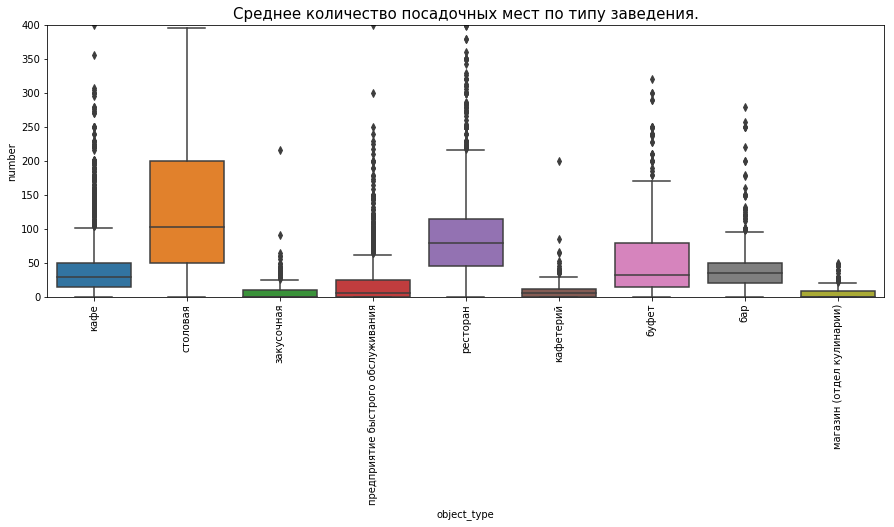

In [67]:
plt.figure(figsize=(15, 5))
sns.boxplot(x='object_type', y='number', data=rest)
plt.ylim(0, 400)
plt.title('Среднее количество посадочных мест по типу заведения.', fontsize=15) 
plt.xticks(rotation=90)
plt.show()

Text(0.5, 1.0, 'Среднее количество посадочных мест по типу заведения.')

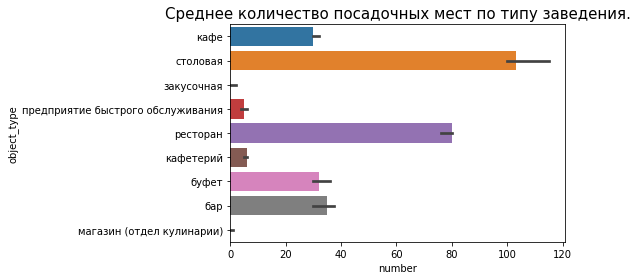

In [68]:
sns.barplot(x='number', y='object_type', data=rest, estimator=median)
plt.title('Среднее количество посадочных мест по типу заведения.', fontsize=15) 

Больше всего в среднем посадочных мест в столовых, а так же ресторанах.

***************
* _Посмотрим на общие характеристики заведений:_

In [69]:
rest\
.groupby('object_type')\
['number'].describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])\
.style.background_gradient('Reds')

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
object_type,,,,,,,,,,,,
бар,856,43.4942,67.0829,0,0,8.5,20,35,50,84,189,1700
буфет,585,51.1299,56.332,0,0,0,14,32,80,120,250,320
закусочная,360,7.60833,16.6509,0,0,0,0,0,10,22.1,60,216
кафе,6099,39.716,37.7209,0,0,6,15,30,50,84,190,533
кафетерий,398,9.12312,14.6391,0,0,0,0,6,12,21,53.33,200
магазин (отдел кулинарии),273,5.58974,9.87273,0,0,0,0,0,8,16,45,50
предприятие быстрого обслуживания,1923,20.5523,38.367,0,0,0,0,5,25,60,168.68,580
ресторан,2285,96.8341,94.7565,0,0,30,46,80,114,180,478.48,1500
столовая,2587,130.247,95.1793,0,6.86,30,50,103,200,240,330,1400


В барах от 0 до 1700 мест, среднее количество посадочных мест 35, а большинство на 50 мест.

В буфетах от 0 до 320 мест, среднее количество посадочных мест 32, а большинство в 2,5 раза больше - на 80 мест. Те же есть довольно большой разброс между медианой и средним.

Закусочные часто без посадочных мест, но большинство не более 10 мест. Есть и аномалии в 216 мест, возможно это связано с упрощенным оформлением.

Кафе бывают и без посадочных мест, а бывают и на 533 человека, среднее количество посадочных мест 30, а большинство на 50 мест.

В кафетерии от 0 до 200 мест, среднее количество посадочных мест 6, а большинство на 12 мест.

В кулинариях от 0 до 50 мест, в половине посадочных мест нет.

Для предприятий быстрого обслуживания характерен разброс посадочных мест как у кафе от 0 до 580, среднее количество посадочных мест 5, а большинство на 25 мест. Так же характерен большой разброс медиана 5, а среднее уже в 4 раза больше - 20. Возможно есть "аномально")) большие фаст-фуды.

В ресторане от 0 до 1500 мест, среднее количество посадочных мест 80, но большинство на 114 мест.

Столовые от 0 до 1400 мест, среднее количество посадочных мест 103, а большинство на 200 мест.

****************

**2.6.Выделим в отдельный столбец информацию об улице из столбца address.**<a id='102105'></a>

In [70]:
#создадим новую переменную, чтобы не потерять важные данные:
rest_moscow = rest
rest_moscow['address']=rest_moscow['address'].replace('город Москва,','',regex=True)
rest_moscow.head(10)

,id,object_name,chain,object_type,address,number
0,151635,сметана,нет,кафе,"улица Егора Абакумова, дом 9",48
1,77874,родник,нет,кафе,"улица Талалихина, дом 2/1, корпус 1",35
2,24309,кафе «академия»,нет,кафе,"Абельмановская улица, дом 6",95
3,21894,пиццетория,да,кафе,"Абрамцевская улица, дом 1",40
4,119365,кафе «вишневая метель»,нет,кафе,"Абрамцевская улица, дом 9, корпус 1",50
5,27429,стол. при гоу сош № 1051,нет,столовая,"Абрамцевская улица, дом 15, корпус 1",240
6,148815,брусника,да,кафе,"переулок Сивцев Вражек, дом 6/2",10
7,20957,буфет мтуси,нет,столовая,"Авиамоторная улица, дом 8, строение 1",90
8,20958,кпф семья-1,нет,столовая,"Авиамоторная улица, дом 8, строение 1",150
9,28858,столовая мтуси,нет,столовая,"Авиамоторная улица, дом 8, строение 1",120


In [71]:
#переименуем, найденные на первый взгляд, названия дублирующие друг друга:
rest_moscow['address']=rest_moscow['address'].replace('посёлок Внуково,','поселение Внуковское',regex=True)
rest_moscow['address']=rest_moscow['address'].replace('город Московский,','поселение Московский',regex=True)

In [72]:
#удалим название города, чтобы было проще работать с улицами:
rest_moscow['street'] = rest_moscow['address'].str.split(r',\s*').str[0]
#rest_moscow

*****************

**2.7.Построим график топ-10 улиц по количеству объектов общественного питания. Воспользуемся внешней информацией и ответим на вопрос — в каких районах Москвы находятся эти улицы?**<a id='102106'></a>

In [73]:
sum_street = rest_moscow.groupby('street')['id'].count().sort_values(ascending=False).reset_index()
sum_street.head(10)

,street,id
0,город Зеленоград,232
1,проспект Мира,204
2,Профсоюзная улица,182
3,Ленинградский проспект,171
4,Пресненская набережная,167
5,Варшавское шоссе,161
6,Ленинский проспект,147
7,поселение Сосенское,138
8,проспект Вернадского,132
9,Кутузовский проспект,114


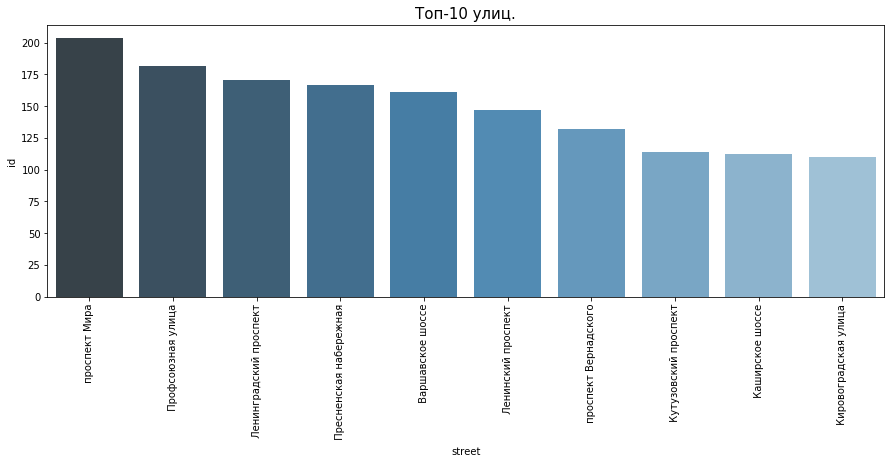

In [74]:
#удалим улицы из удаленных районов:
sum_street = sum_street.query('street != (" город Зеленоград", " поселение Сосенское")')
sum_street = sum_street.query('id > 105')
plt.figure(figsize=(15, 5))
sns.barplot(x='street', y='id', palette="Blues_d", data=sum_street)
plt.title('Топ-10 улиц.', fontsize=15) 
plt.xticks(rotation=90)
plt.show()

Большинство этих объектов - проспекты, что предполагает, большую протяженность, что, в свою очередь влияет на возможность размещения на них большего чем на обычных улицах, количества заведений.
************
Так же размер проспектов можно представить исходя из того, что расположены они в нескольких районах, а иногда и в нескольких округах.
*************

Проспект Мира -  Алексеевский, Марьина роща, Мещанский, Останкинский, Ростокино, Свиблово и Ярославский на территории СВО и ЦАО.

Профсоюзная улица - Академический, Коньково, Обручевский, Тёплый Стан, Черёмушки и Ясенево на территории ЮЗАО.

Ленинградский проспект - Аэропорт, Беговой, Сокол и Хорошёвский на территории САО.

Пресненская набережная - Пресненском районе на территории ЦАО.

Варшавское шоссе - Северное Бутово, Южное Бутово, Донской, Нагатино-Садовники, Нагорный, Северное Чертаново, Центральное Чертаново и Южное Чертаново на территории ЮЗАО и ЮАО.

Ленинский проспект - Гагаринский, Донской, Ломоносовский, Обручевский, Проспект Вернадского, Тёплый Стан, Тропарёво-Никулино и Якиманка на территории ЮЗАО, ЮАО, ЗАО и ЦАО.

Проспект Вернадского - Гагаринский, Ломоносовский, Проспект Вернадского, Раменки и Тропарёво-Никулино на территории ЮЗАО и ЗАО.

Кутузовский проспект - Дорогомилово и Фили-Давыдково на территории ЗАО.

Каширское шоссе - Москворечье-Сабурово, Нагатино-Садовники, Северное Орехово-Борисово и Южное Орехово-Борисово на территории ЮАО.

Кировоградская улица -  Северное Чертаново, Центральное Чертаново и Южное Чертаново на территории ЮАО.

**Подавляющее большинство этих улиц проходит по ЮЗАО и ЮАО, так же много в ЗАО и ЦАО, и минимум в СВО и САО.**

************

**2.8.Найдем число улиц с одним объектом общественного питания. Воспользуемся внешней информацией и ответим на вопрос — в каких районах Москвы находятся эти улицы?**<a id='102107'></a>

In [75]:
#сделаем срез улиц с одним объектом:
one_street = rest_moscow.groupby('street')['id'].count().sort_values().reset_index()
one_street = one_street.query('id == 1')
#некоторые видимые поселения удалим вручную: 
one_street = one_street.query('street != (" поселение Филимонковское", " поселение Московский улица Никитина", "поселение Сосенское", "поселение Московский улица Хабарова", "поселение Михайлово-Ярцевское", "поселение Марушкинское", "город Троицк", " посёлок Акулово")')
#сколько всего таких улиц:
print(one_street['id'].sum())
#one_street

578


In [76]:
#сделаем случайную выборку примерно 10% улиц (на основе метода sample):
street_one_58 = pd.DataFrame(one_street, index=[121, 117, 565, 8, 534, 336, 355, 4, 9, 324, 337, 73, 196, 468, 263, 516, 343, 207, 249, 572, 38, 273, 521, 283, 190, 257, 180, 276, 375, 151, 345, 492, 164, 262, 390, 100, 150, 495, 420, 436, 108, 178, 418, 502, 485, 406, 275, 21, 24, 331, 509, 469, 265, 476, 119, 13, 26, 396])

#print(street_one_58.shape)
street_one_58 = street_one_58[['street']]
street_one_58

,street
121,Большой Строченовский переулок
117,улица Екатерины Будановой
565,улица Пржевальского
8,проезд Якушкина
534,1-й Ботанический проезд
336,Мерзляковский переулок
355,2-й Лучевой просек
4,Институтский переулок
9,проезд Черепановых
324,Молодёжная улица


* _Возьмем данные с сайта http://округа-районы.москва об округах и районах нужных улиц._

In [77]:
#посмотрим на данные:
from pandas import read_csv
ul=pd.read_excel('viborka.xlsx', header=[0], index_col=None)
ul.columns = ['street', 'type', 'area', 'district']
#т.к. данные извлекали по списку и их немного, просто проверим соответствие из этой же таблицы, чтобы не делать лишнюю работу:
ul

,street,type,area,district
0,Большой Строченовский,пер,ЦАО,район Замоскворечье
1,Екатерины Будановой,ул,ЗАО,район Кунцево
2,Пржевальского,ул,ЗАО,район Очаково-Матвеевское
3,Якушкина,проезд,СВАО,район Отрадное
4,1-й Ботанический,проезд,СВАО,район Свиблово
5,Мерзляковский,пер,ЦАО,Пресненский район
6,2-й Лучевой,просек,ВАО,район Сокольники
7,Институтский,пер,СВАО,район Марьина роща
8,Черепановых,проезд,САО,район Коптево
9,Молодёжная,ул,ЮЗАО,Гагаринский район


In [78]:
type_ = ul['type'].value_counts()
type_

ул        22
пер       19
проезд    12
линия      1
пл         1
просек     1
пр-кт      1
ш          1
Name: type, dtype: int64

Большинство объектов это простые улицы, переулки и проезды.
************
* _Теперь посмотрим их распределение по округам:_

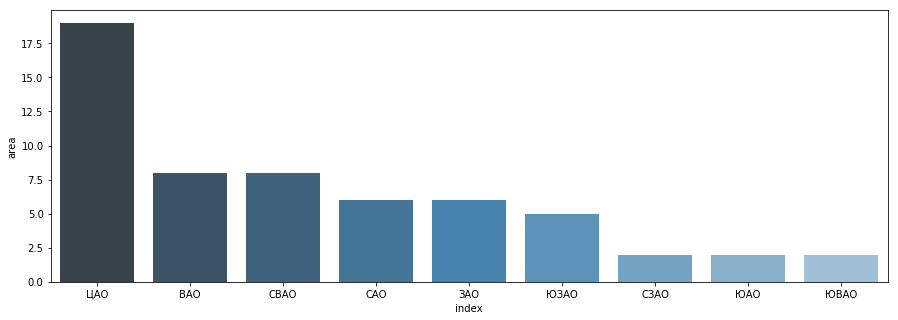

In [79]:
area = ul['area'].value_counts().reset_index()
#print(area)
plt.figure(figsize=(15, 5))
sns.barplot(x='index', y='area', palette="Blues_d", data=area)
plt.show()

Большинство улиц находится в центральном округе, возможно это связано с тем, что там много маленьких улиц, переулков и мало объектов недвижимости, а так же со стоимостью аренды.

* _Распределение по районам:_

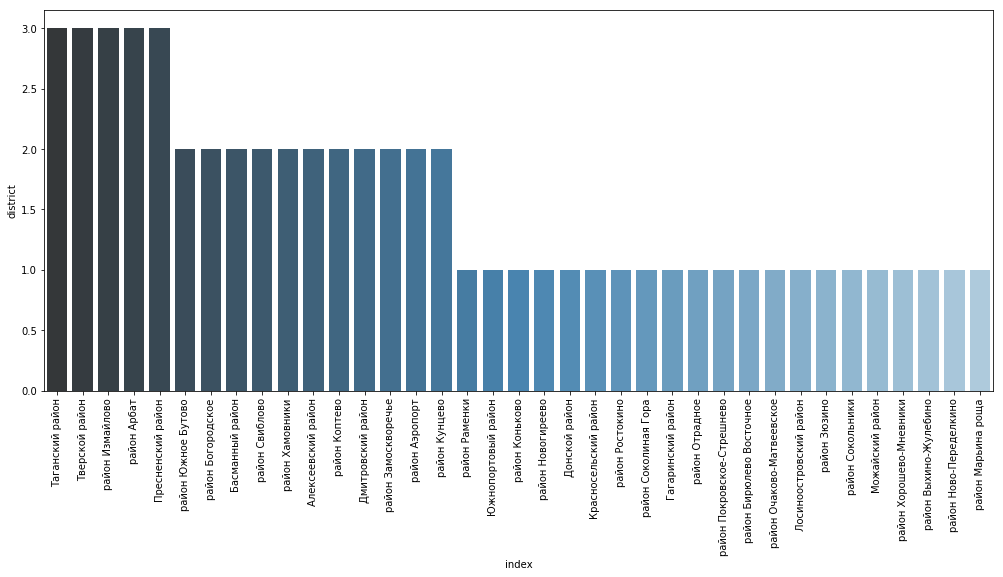

In [80]:
district = ul['district'].value_counts().reset_index()
district
plt.figure(figsize=(17, 7))
sns.barplot(x='index', y='district', palette="Blues_d", data=district)
plt.xticks(rotation=90)
plt.show()

По 3 улицы с одним объектом общественного питания в Пресненском, Таганском, Тверском и Измайловском районах, кроме Измайловского, это могут быть улицы с исторической застройкой с малым метражом недвижимости. Можно поделить эти данные на 2 вида: историческая застройка, где мало места и высокая цена на аренду, но возможно большая проходимость, и улицы в районах с новостройками. Возможно, среди них есть оптимальные варианты.

**************

**2.9.Посмотрим на распределение количества посадочных мест для улиц с большим количеством объектов общественного питания. Выявим закономерности.**<a id='102108'></a>

In [81]:
#сделаем срез:
big_street = rest_moscow.query('street == (" проспект Мира", " Профсоюзная улица", " Ленинградский проспект", " Прененская набережная", " Варшавское шоссе", " Ленинский проспект", " проспект Вернадского", " Кутузовский проспект", " Каширское шоссе", " Кировоградская улица")')
big_street.head()

,id,object_name,chain,object_type,address,number,street
151,155973,кафе «андерсон»,да,кафе,"Варшавское шоссе, дом 2",150,Варшавское шоссе
152,23618,кафе «subway»,да,кафе,"Варшавское шоссе, дом 7, корпус 1",36,Варшавское шоссе
153,155852,кафе «ламаджо»,нет,кафе,"Варшавское шоссе, дом 29",30,Варшавское шоссе
154,152556,шаурма в пите,нет,предприятие быстрого обслуживания,"Варшавское шоссе, дом 72, корпус 2",0,Варшавское шоссе
155,120658,выпечка,нет,кафетерий,"Варшавское шоссе, дом 100",2,Варшавское шоссе


Данный срез составляет 8,7% от общего числа заведений.

In [82]:
set4 = big_street.groupby('street')[['number']].sum().join(big_street.groupby('street')[['id']].count()).reset_index()
set4['ratio'] = (set4['number'] / set4['id']).round()
set4['ratio'] = set4['ratio'].astype(int)
set4

,street,number,id,ratio
0,Варшавское шоссе,8513,161,53
1,Каширское шоссе,6171,112,55
2,Кировоградская улица,6577,110,60
3,Кутузовский проспект,9697,114,85
4,Ленинградский проспект,9010,171,53
5,Ленинский проспект,9330,147,63
6,Профсоюзная улица,8447,182,46
7,проспект Вернадского,8840,132,67
8,проспект Мира,12790,204,63


Эти улицы можно в общем охарактеризовать тем, что здесь в среднем 120-140 заведений на улице, со средним количеством посадочных мест - 60. 
* _Посмотрим подробнее:_

Text(0.5, 1.0, 'Среднее количество типов заведений на больших улицах.')

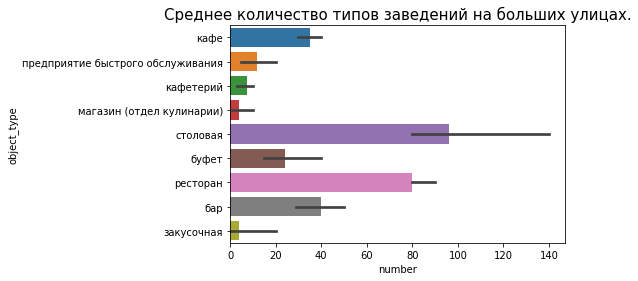

In [83]:
sns.barplot(x='number', y='object_type', data=big_street, estimator=median)
plt.title('Среднее количество типов заведений на больших улицах.', fontsize=15) 

На этих улицах преобладают столовые и рестораны.

([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text xticklabel objects>)

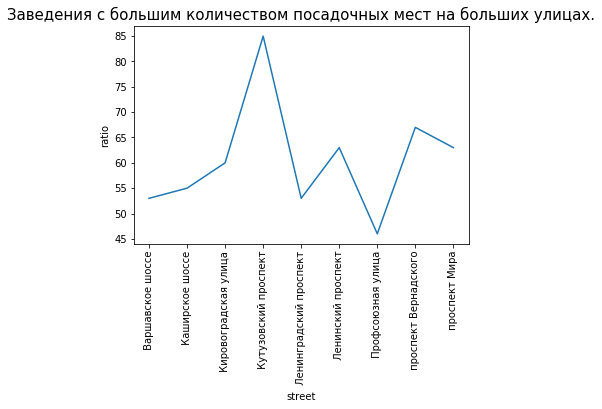

In [84]:
sns.lineplot(x='street', y='ratio', data=set4)
plt.title('Заведения с большим количеством посадочных мест на больших улицах.', fontsize=15) 
plt.xticks(rotation=90)

Text(0.5, 1.0, 'Среднее количество посадочных мест на больших улицах.')

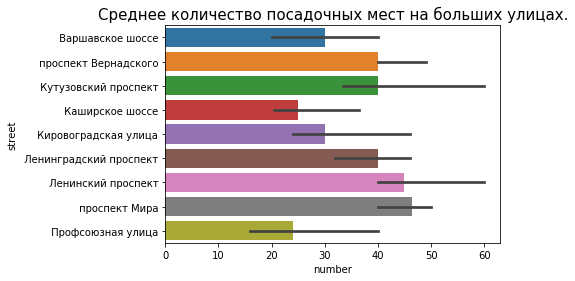

In [85]:
sns.barplot(x='number', y='street', data=big_street, estimator=median)
plt.title('Среднее количество посадочных мест на больших улицах.', fontsize=15) 

В заведениях на проспектах большее количество посадочных мест (40), на улицах и шоссе (25-30). Вероятно, это связано с проходимостью. Но из графика boxplot видно, что заведения довольно разнообразны (много выбросов). Если по среднему количеству посадочных мест на предыдущем графике лидирует Кутузовский проспект, то на boxplot лидирует Проспект Мира. Вероятно, на Кутузовском проспекте есть несколько больших заведений.

# 3.Вывод:<a id='100103'></a>

* Представлено 15366 заведений в городе Москва.

* Было исследовано соотношение видов объектов общественного питания по количеству. Представлено 9 типов заведений - больше всего кафе(6099), а меньше всего кулинарий (273). По убыванию: 39,7% - кафе, 16,8% - столовая, 14,9% - ресторан, 12,5% фаст-фуд, бар - 5,57%, 3,81% - буфет, 

* Соотношение сетевых и несетевых заведений 1 к 4 - 2968 сетевых(19,3%) и 12398(80,7%) несетевых заведений.

Для сетевого типа характерны: кафе(47%), фаст-фуд(26,7%) и рестораны(18,3%). У несетевого типа преобладает так же кафе(37,9%), затем есть существенные различия - столовая (20,8%), ресторан (14%) и фаст_фуд (9, 13%). Для сетевых заведений характерно - большое количество заведений с довольно средним количеством посадочных мест у кафе(47) и фаст-фуда(40) и с большим количеством посадочных мест у ресторанов(100).

Среднее количество посадочных мест в сетевых – 53 (но по медиане - 40, значит есть значительные расхождения между заведениями, или много заведений без посадочных мест или наоборот с очень большим их количеством). Среди несетевых заведений расхождение между средним и медианой еще больше - медиана все те же 40, а среднее 61.

Обращает на себя внимание факт, что сетевых столовых в Москве практически нет, а в несетевом секторе они на втором месте - 20,8%.

Посмотрим на сети с самым большим количеством ресторанов.
На первых местах - Шоколадница, KFC, Макдоналдс, Бургер Кинг (возможно использовать их опыт).


* Среднее количество посадочных мест для каждого вида объекта общественного питания. Больше всего в среднем посадочных мест в столовых (от 0 до 1400) при среднем 103-200, а так же ресторанах (от 0 до 1500)при среднем 80-114. Выделяются бары (от 0 до 1700) при среднем количестве посадочных мест – 35-50. Где-то есть гигантский бар)).  Далее идут схожие сегменты кафе(от 0 до 533) при среднем 30-50 мест и фаст-фуды (от 0 до 580) при среднем 5-25 мест. Далее кафетерии (от 0 до 200) при среднем 6-12 мест,  буфеты (от 0 до 320) при среднем 32-80 (разброс в 2,5 раза) и закусочные (от 0 до 216) часто без посадочных мест, но большинство не более 10 мест. И самый маленький сегмент это кулинарии от 0 до 50 мест, в половине из них посадочных мест нет.


* Топ-10 улиц по количеству объектов общественного питания. Данный срез составляет 8,7% от общего числа заведений.

Большинство проспекты, что предполагает, большУю протяженность, что, в свою очередь влияет на возможность размещения на них большего, чем на обычных улицах, количества заведений. Так же размер проспектов можно представить исходя из того, что расположены они в нескольких районах, а иногда и в нескольких округах.

Подавляющее большинство этих улиц проходит по ЮЗАО и ЮАО, так же много в ЗАО и ЦАО, и минимум в СВО и САО.
для улиц с большим количеством объектов общественного питания. Выявим закономерности.
На этих улицах преобладают столовые и рестораны. В заведениях на проспектах большее количество посадочных мест (40), на улицах и шоссе (25-30). Вероятно, это связано с проходимостью. Но из графика boxplot видно, что заведения довольно разнообразны (много выбросов). Если по среднему количеству посадочных мест на предыдущем графике лидирует кутузовский проспект, то на boxplot лидирует Проспект Мира. Вероятно, на Кутузовском проспекте есть несколько больших заведений.


* 578 улиц с ОДНИМ объектом общественного питания. Большая часть это простые улицы, переулки и проезды. Большинство улиц в центральном округе, возможно это связано с тем, что там много маленьких улиц, переулков и мало объектов недвижимости, а так же со стоимостью аренды. По 3 улицы с одним объектом общественного питания в Пресненском, Таганском, Тверском и Измайловском районах, кроме Измайловского, это могут быть улицы с исторической застройкой с малым метражом недвижимости. Практически можно разделить эти данные на 2 вида: историческая застройка, где мало места и высокая цена на аренду, но возможно большая проходимость, и улицы в районах с новостройками. Возможно, среди них есть оптимальные варианты.

* **Возможные аномалии.** В несетевом типе заведений: в столовой, баре и буфете есть аномально большие значения посадочных мест, а так же у закусочных и кафетериев. В сетевом типе – у фаст-фудов есть большой разброс между медианой (5), а среднее уже в 4 раза больше - 20. Возможно, есть "аномально")) большие фаст-фуды.


# 4.Рекомендации:<a id='100104'></a>

**Основываясь на информации, что в некоторых районах высокая концентрация заведений общественного питания, можно предположить, что там хороший спрос на услуги общественного питания, высокая конкуренция, а, учитывая, что у нас есть конкурентное преимущество (роботы официанты) и спрос на наши услуги неэластичный, которые могут привлечь большое кол-во посетителей (многие захотят не только покушать, но и сделать сэлфи с роботом). Можно открыть кафе на любой из топ-10 улиц рядом с метро. Среднее количество посадочных мест рекомендую, 30-40.**